2개의 특성과 3개의 라벨로 분류 문제 

- label 개수: 3개 (ToVol) 
- feature 개수 : 2개(Speed, OccRate)
- DNN, SVC, VQC, QSVC 성능 비교

In [1]:
import datetime
import time
import qiskit
import tensorflow 
import platform

datetime.datetime.now()

print('qiskit version:', qiskit.__version__)
print('tf     version:', tensorflow.__version__)
print('Python Version:',platform.python_version())
print('OS            :', platform.system())
print('코딩시간       :', time.strftime("%a %b %d %H:%M:%S %Y %Z"))
print('Copyright     : Hongsuk (hongsuk.yi@gmail.com)')

qiskit version: 1.2.4
tf     version: 2.18.0
Python Version: 3.9.21
OS            : Windows
코딩시간       : Thu Mar 20 16:52:32 2025 대한민국 표준시
Copyright     : Hongsuk (hongsuk.yi@gmail.com)


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from mlxtend.plotting import plot_decision_regions

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

## 포팅

In [5]:
# from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.algorithms import VQC, QSVC, NeuralNetworkClassifier 

from qiskit.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2, TwoLocal
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils import algorithm_globals

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")
df = pd.read_csv("./vds16_L3_120m_Days20.csv")

## Feature selection

In [8]:
df.info

<bound method DataFrame.info of      Unnamed: 0         Day   Hour   avg_Den     avg_Vol    avg_Spd  \
0             0  2017-04-03  00:00  0.026100   19.458333  58.845833   
1             1  2017-04-03  02:00  0.012216   13.333333  64.529167   
2             2  2017-04-03  04:00  0.052678   35.041667  59.033333   
3             3  2017-04-03  06:00  0.414446  178.041667  48.475000   
4             4  2017-04-03  08:00  0.423664  190.666667  47.066667   
..          ...         ...    ...       ...         ...        ...   
235         235  2017-04-28  14:00  0.356722  162.208333  46.591667   
236         236  2017-04-28  16:00  0.364749  163.416667  46.170833   
237         237  2017-04-28  18:00  0.479602  169.625000  38.720833   
238         238  2017-04-28  20:00  0.256651  112.958333  44.725000   
239         239  2017-04-28  22:00  0.155431   76.958333  49.854167   

       avg_Occ     Label  
0     0.812917  Fast_Low  
1     0.921250  Fast_Low  
2     1.729167  Fast_Low  
3     9

In [9]:
df.head()

,Unnamed: 0,Day,Hour,avg_Den,avg_Vol,avg_Spd,avg_Occ,Label
0,0,2017-04-03,00:00,0.026100,19.458333,58.845833,0.812917,Fast_Low
1,1,2017-04-03,02:00,0.012216,13.333333,64.529167,0.921250,Fast_Low
2,2,2017-04-03,04:00,0.052678,35.041667,59.033333,1.729167,Fast_Low
3,3,2017-04-03,06:00,0.414446,178.041667,48.475000,9.987083,Jam_High
4,4,2017-04-03,08:00,0.423664,190.666667,47.066667,10.216250,Jam_High


In [10]:
# 'Hour' 컬럼을 datetime 형식으로 변환
df['Hour'] = pd.to_datetime(df['Hour'], format='%H:%M')

# datetime 객체에서 시간(hour)만 추출
df['Hour_int'] = df['Hour'].dt.hour

# 이제 df['Hour_int'] 컬럼에 0~24 사이의 시간 정수 값이 저장됩니다.
#X = df[['Hour_int']]


In [11]:
df.columns

Index(['Unnamed: 0', 'Day', 'Hour', 'avg_Den', 'avg_Vol', 'avg_Spd', 'avg_Occ',
       'Label', 'Hour_int'],
      dtype='object')

<Axes: xlabel='avg_Den', ylabel='avg_Vol'>

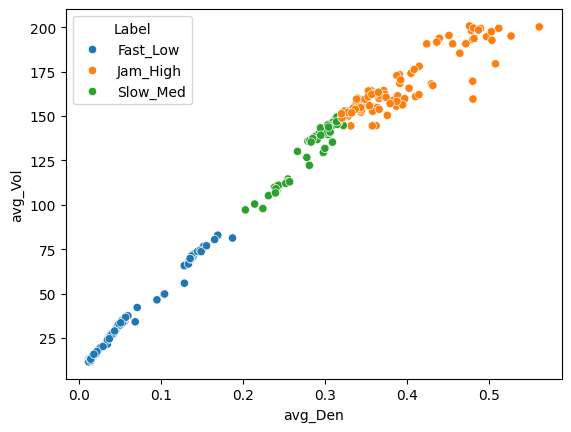

In [12]:
sns.scatterplot(df, x = 'avg_Den', y = 'avg_Vol', hue='Label') 

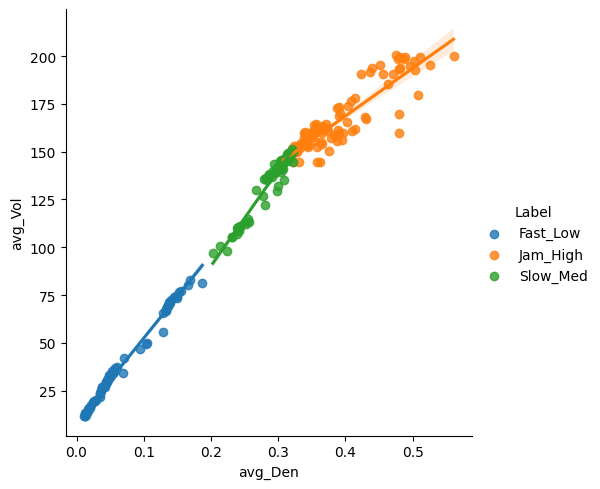

In [13]:
sns.lmplot(x = 'avg_Den', y = 'avg_Vol', hue='Label', data=df)

# Classical classifiers 

In [14]:
# classical SVM
X = df[['avg_Den', 'avg_Vol', 'avg_Spd', 'Hour_int']]
y = df['Label']

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[:5,:])

(240, 4)
[[-1.54172876 -1.61781651  1.77244733 -1.59325501]
 [-1.63635494 -1.72283416  2.83439754 -1.30357228]
 [-1.36058523 -1.35062876  1.80748234 -1.01388955]
 [ 1.10504787  1.10121184 -0.16537824 -0.72420682]
 [ 1.1678697   1.31767679 -0.42853013 -0.43452409]]


In [16]:
y_enc = LabelEncoder().fit_transform(y)
print(y_enc[:100])

[0 0 0 1 1 2 2 2 2 1 2 0 0 0 0 1 1 2 2 2 1 1 2 0 0 0 0 1 1 2 2 2 1 1 2 0 0
 0 0 1 1 2 2 1 1 1 2 0 0 0 0 1 1 2 1 1 1 1 2 0 0 0 0 1 1 2 2 1 1 1 2 0 0 0
 0 1 1 2 2 2 2 1 2 0 0 0 0 1 1 2 1 1 1 1 2 0 0 0 0 1]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.20)

In [18]:
X_test2F=X_test[:, :2]
X_test2F.shape

(48, 2)

## SVM

In [19]:
acc_sv=0.0
acc_ann=0.0
acc_dnn=0.0
acc_qsvc=0.0
acc_vqc=0.0

In [20]:
# Create svm Classifier
model  = SVC()
svm = model.fit(X_train, y_train)

In [21]:
y_pred = model.predict(X_test)

acc_svc =  metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_svc)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 1.0

- Confustion Matrix:
 [[19  0  0]
 [ 0 15  0]
 [ 0  0 14]]

- Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [22]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 

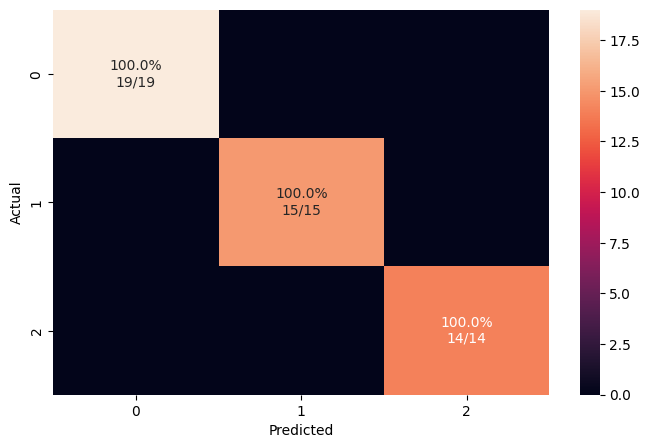

In [23]:
 cm_analysis(y_test, y_pred, labels=None, ymap=None, figsize=(8,5)) 

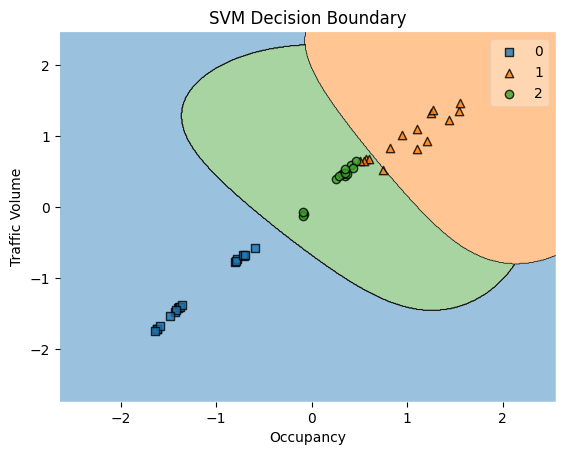

In [24]:
model.fit(X_test2F, y_test)

plot_decision_regions(X_test2F, y_test, clf=model)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('SVM Decision Boundary')
plt.show()

## ANN

In [25]:
# classical QNN 
model_ann = MLPClassifier(max_iter=1000,  random_state=5)
model = model_ann
model = model.fit(X_train, y_train)

In [26]:
y_pred = model.predict(X_test)
acc_ann = metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_ann)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 0.9583333333333334

- Confustion Matrix:
 [[19  0  0]
 [ 0 15  0]
 [ 0  2 12]]

- Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.88      1.00      0.94        15
           2       1.00      0.86      0.92        14

    accuracy                           0.96        48
   macro avg       0.96      0.95      0.95        48
weighted avg       0.96      0.96      0.96        48



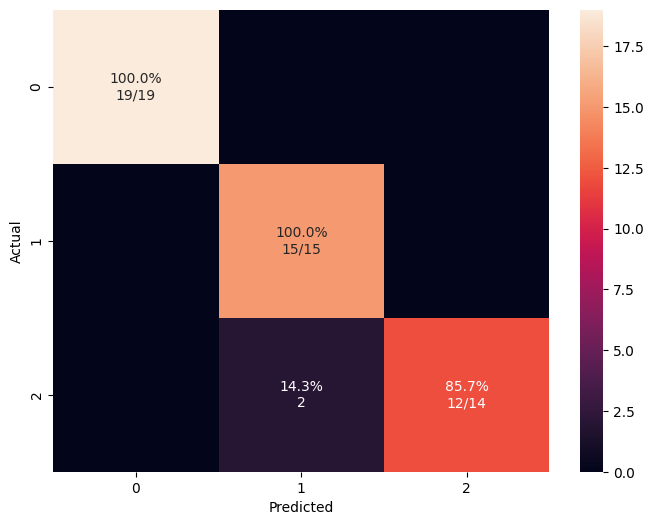

In [27]:
cm_analysis(y_test, y_pred,labels=None, ymap=None, figsize=(8,6)) 

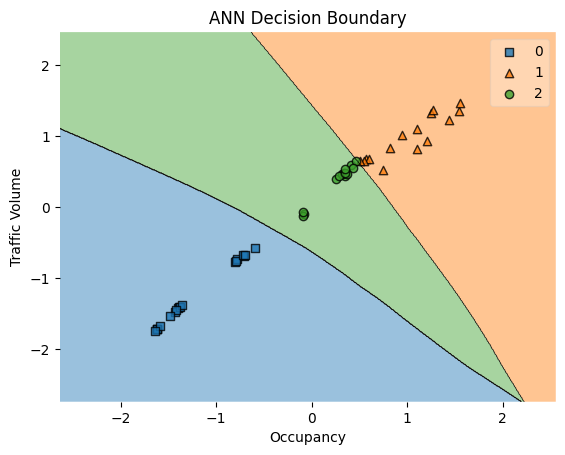

In [28]:
model.fit(X_test2F, y_test)

plot_decision_regions(X_test2F, y_test, clf=model)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('ANN Decision Boundary')
plt.show()

## Deep Neural Network MLP

In [29]:
num_classes = y.nunique()
print(f"클래스 개수: {num_classes}")

num_features = X_train.shape[1]
print('특성 개수  :',num_features)

클래스 개수: 3
특성 개수  : 4


In [30]:
model_dnn = Sequential([
    Dense(64, input_dim=num_features, activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  
model_dnn2 = Sequential([
    Dense(64, input_dim= 2, activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  

In [31]:
model = model_dnn
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = 'adam', metrics = ['accuracy'])

In [32]:
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2,verbose=0)

In [33]:
_, acc_dnn = model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9514 - loss: 0.1753


In [34]:
print("\n- Accuracy of Classical DNN:",acc_dnn)


- Accuracy of Classical DNN: 0.9583333134651184


In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

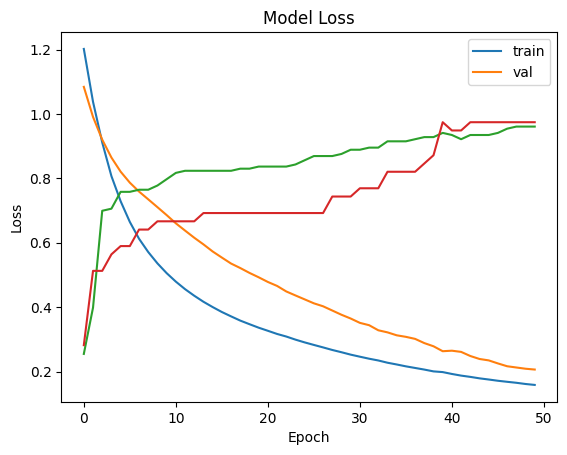

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


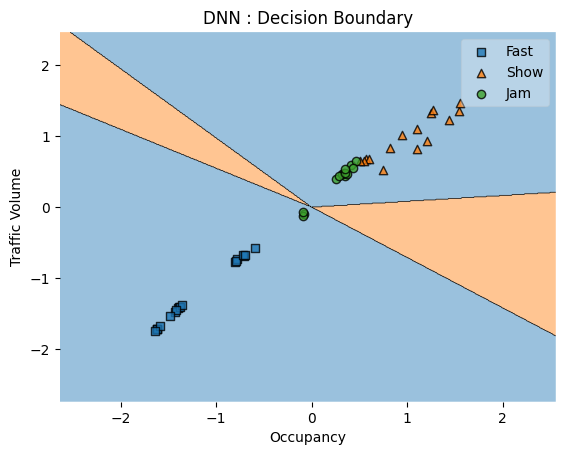

In [37]:
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)   

model_one =Onehot2Int(model_dnn2)

ax=plot_decision_regions(X_test2F, y_test, clf=model_one)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('DNN : Decision Boundary')

handles, labels = ax.get_legend_handles_labels()
if num_classes == 3 : 
    ax.legend(handles, [ 'Fast', 'Show', 'Jam'],  framealpha=0.3, scatterpoints=1)
plt.show()


# Quantum Simulator for Quantum Classification

In [38]:
import time
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit.circuit.library import ZZFeatureMap,  RealAmplitudes
# from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

### 1) VQC

feature map
- from classical data to qubit through data encoding, data embedding, data loading
- The most standard fearture is ZZFeatureMap

ansatz

- apply a parameterize quantum circuit.
- objective function characterized the distance between the prediction and known labeled data.
- A parametrized quantum circuit is call a paramenterized trial state, variational form, or ansatz.- 

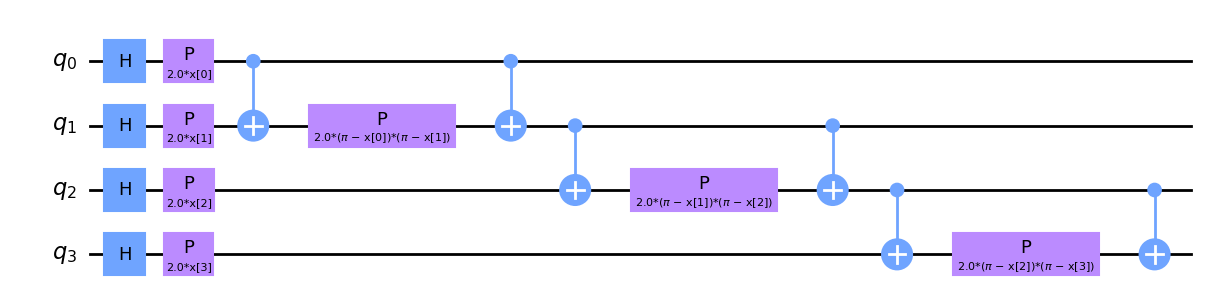

In [39]:
feature_map = ZZFeatureMap(feature_dimension = num_features , reps=1, entanglement="linear")
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

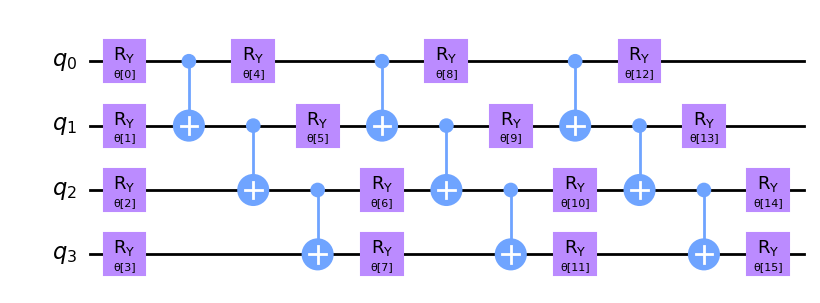

In [40]:
ansatz = RealAmplitudes(num_qubits = num_features , reps=3,entanglement="linear")
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

StatevectorSampler를 이용한 Simulator

In [41]:
sampler = Sampler()

In [42]:
def multi_class_interpret(measured_integer):
    """측정된 정수를 num_classes으로 나눈 나머지를 클래스 인덱스로 반환"""
    return measured_integer % num_classes
    
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Onh-hot encoded format의 경우 crossEntropyLoss를 사용한다.

In [43]:
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
optimizer = COBYLA(maxiter=100)

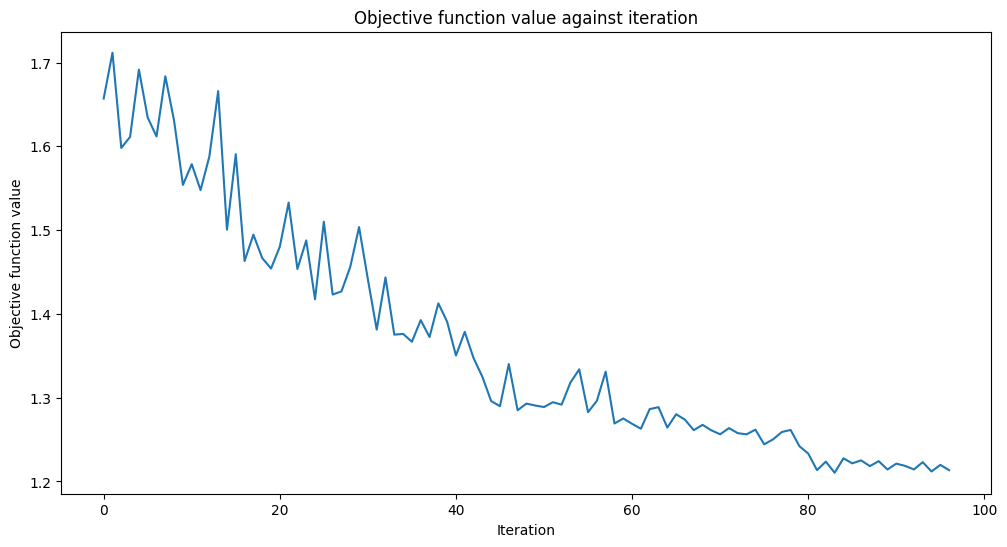

In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    output_shape=num_classes,
    interpret=multi_class_interpret  # interpret 함수 추가
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(X_train, y_train)
acc_vqc = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset    : {acc_vqc:.2f}")

In [ ]:
cost_vqc_train = objective_func_vals

In [ ]:
# 훈련 정확도 그래프
plt.plot(cost_vqc_train)
#plt.plot(history.history['val_accuracy'])
plt.title('Train Process')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['VQC train'])
plt.show()

VQC performance

In [ ]:
# classification report of VQC

y_pred = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(y_test, y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))

In [ ]:
predict = vqc.predict(X_test)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test}")

In [ ]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

### 2) Quantum SVC

In [ ]:
fm_qsvc = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2, entanglement="linear")
fm_qsvc.decompose().draw(output="mpl", style="clifford", fold=20)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qsvc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm_qsvc)
qsvc = QSVC(quantum_kernel=qsvc_kernel)

In [ ]:
start = time.time()
qsvc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
acc_qsvc = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {acc_qsvc}")

In [ ]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

In [ ]:
# classification report of QSVC
y_pred = qsvc.predict(X_test) 
metrics.classification_report(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
print(f"acc_svc 타입: {type(acc_svc)}")
print(f"acc_ann 타입: {type(acc_ann)}")
print(f"acc_dnn 타입: {type(acc_dnn)}")
print(f"acc_qsvc 타입: {type(acc_qsvc)}")
print(f"acc_vqc 타입: {type(acc_vqc)}")